In [28]:
%run ./funcoes.ipynb

In [29]:
from sklearn.model_selection import train_test_split
#Carga dos dados já parcialmente tratados
arquivo_base = "INFLUD21-29-03-2021.csv"  
ext_file = "_processed_pre_dummies.csv"
rad_filename = arquivo_base[:-4]  #exclui a extensão do arquivo
filename_pre_des = rad_filename + ext_file
covid_df = load_df(filename_pre_des,";",None,None)  #carrega os dados

Arquivo informado: INFLUD21-29-03-2021.csv
Verifica existencia do arquivo: True
Arquivo INFLUD21-29-03-2021_143_proc_smote_over.csv foi encontrado.
Carregando o arquivo...
Concluído.


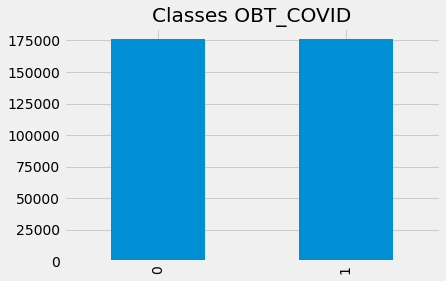

In [30]:
#Converte os tipos das variaveis do dataframe
covid_df_cat = converte_tipo_category(covid_df)
#Converte as variáveis categóricas em binárias (dummies)
covid_df_bin = converte_binarios(covid_df_cat) 
#Normalizada as colunas contínuas
covid_df_nor = normaliza_dados(covid_df_bin)
# Balanceamento da base de desenvolvimento Com SMOTE oversampling
covid_df_train_bal = imblearn_SMOTE_oversampling(covid_df_nor,arquivo_base,False,'OBT_COVID')

In [31]:
labels = covid_df_train_bal.columns[:-1]  # presume-se que a última variável do dataframe é a alvo
X = covid_df_train_bal[labels]
y = covid_df_train_bal['OBT_COVID']

In [32]:
from sklearn.model_selection import train_test_split
# Split the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=42,
  shuffle=True, stratify=y)

In [33]:
covid_df_train_bal

,NU_IDADE_N,GeoSES,AN_SARS2_1.0,AN_SARS2_9.0,ASMA_1.0,ASMA_2.0,ASMA_9.0,CARDIOPATI_1.0,CARDIOPATI_2.0,CARDIOPATI_9.0,...,UTI_1.0,UTI_2.0,UTI_9.0,VACINA_1.0,VACINA_2.0,VACINA_9.0,VOMITO_1.0,VOMITO_2.0,VOMITO_9.0,OBT_COVID
0,0.646154,0.662604,0,1,0,1,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0
1,0.546154,0.662604,0,1,0,1,0,0,1,0,...,0,1,0,0,1,0,0,1,0,0
2,0.669231,0.662604,0,1,0,1,0,0,1,0,...,1,0,0,1,0,0,0,1,0,0
3,0.600000,0.662604,0,1,0,1,0,1,0,0,...,0,0,1,0,0,1,0,1,0,1
4,0.661538,0.662604,0,1,0,1,0,1,0,0,...,0,1,0,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351835,0.507239,0.562543,0,1,0,0,1,0,0,1,...,1,0,0,0,1,0,0,0,1,1
351836,0.466494,0.481421,0,1,0,0,1,0,0,1,...,0,1,0,0,0,1,0,0,1,1
351837,0.491169,0.546128,0,1,0,1,0,1,0,0,...,0,0,0,0,1,0,0,1,0,1
351838,0.561398,0.482540,0,1,0,1,0,1,0,0,...,1,0,0,0,1,0,0,1,0,1


In [34]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier

# Inicia o classificador
xtc_cl = ExtraTreesClassifier()

# Treina
xtc_cl.fit(X_train, y_train)

ExtraTreesClassifier()

In [35]:
# Faz predicoes
preds = xtc_cl.predict(X_test)

In [36]:

param_grid_2 = {
    'n_estimators': [160, 165,200,300],
    'criterion' : ["entropy","gini"],
    'max_depth' : [ 55, 60, 65, 70],
    #'n_trees' : [10, 50, 100, 500, 1000, 5000],
    'max_features': [24,28,32,38],
    'min_samples_split': [14,16,18,20]
} 

In [37]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import HalvingRandomSearchCV

#halving_random_cv = HalvingRandomSearchCV(
#    xtc_cl, param_grid_2, scoring="roc_auc", n_jobs=-1,
#    n_candidates="exhaust", factor=4
#)

halving_random_cv = HalvingGridSearchCV(
    xtc_cl, param_grid_2, scoring="roc_auc", n_jobs=-1,
    min_resources="exhaust", factor=3
)

_ = halving_random_cv.fit(X, y)



In [38]:
halving_random_cv.best_score_

0.9348644921686835

In [39]:
_.best_params_ 

{'criterion': 'entropy',
 'max_depth': 65,
 'max_features': 32,
 'min_samples_split': 16,
 'n_estimators': 300}

In [41]:
#params_XTC ={'criterion': 'entropy',
#    'max_depth': 65,
#    'max_features': 38,
#    'min_samples_split': 20,
#    'n_estimators': 300} 

params_XTC ={'n_estimators': 300,
                'min_samples_split': 14,
                'max_features': 32,
                'max_depth': 30,
                'criterion': 'gini'}

# Inicia o classificador
xtc_cl_val = ExtraTreesClassifier(**params_XTC)
xtc_cl_val.fit(X_train, y_train)

ExtraTreesClassifier(max_depth=30, max_features=32, min_samples_split=14,
                     n_estimators=300)

              precision    recall  f1-score   support

           0       0.88      0.88      0.88     43980
           1       0.88      0.88      0.88     43980

    accuracy                           0.88     87960
   macro avg       0.88      0.88      0.88     87960
weighted avg       0.88      0.88      0.88     87960



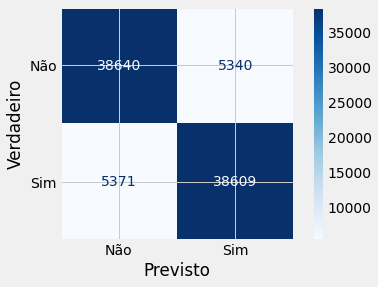

In [25]:
report ={}
report = avalia_modelo(X_test,y_test,xtc_cl_val,report,"_ExtraTree_TOP_feat")

In [21]:
xtc_cl_val

ExtraTreesClassifier()

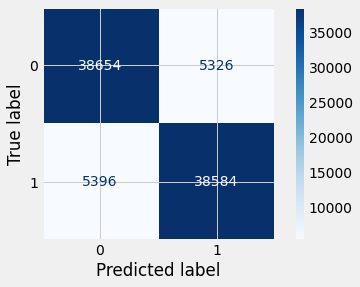

In [18]:
    plot_confusion_matrix(xtc_cl_val, X_test, y_test,cmap=plt.cm.Blues, values_format='d')